In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Activation, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import utils

from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

## 几个可视化函数

对于keras模型，离散分类预测要使用`predict_classes`。

`plot_confusion_matrix`不能用于keras模型，需要自己实现。使用`seaborn.heatmap`可以简单实现一个兼容版本。

In [2]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def plot_confusion_matrix_keras(model, x, y, display_labels=None, values_format='d', cmap='Blues'):
    classes = np.unique(y)
    if display_labels is None:
        display_labels = list(classes)
    d = []
    for cls in classes:
        predictions = model.predict_classes(x[y==cls])
        d.append([np.count_nonzero(predictions==subcls) for subcls in classes])
    d = np.asarray(d)
    sns.heatmap(
        d, cmap=cmap, fmt=values_format,
        annot=True, square=True, xticklabels=display_labels, yticklabels=display_labels
    )
    plt.xlabel('Predicted label')
    plt.ylabel('Truth label')

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    # print loss values
    predictions = clf.predict_proba(xtrain)
    print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
    history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
    predictions = clf.predict_proba(xvalid)
    print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
    history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict_classes(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict_classes(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix_keras(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict_classes(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict_classes(xvalid))

In [3]:
def plot_keras_history(history):
    plt.figure(figsize=(14, 7))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')

    plt.show()
    


## 载入数据及标签化处理

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [5]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [6]:
# we need to binarize the labels for the neural net
ytrain_enc = utils.to_categorical(ytrain)
yvalid_enc = utils.to_categorical(yvalid)

In [7]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

word_index = token.word_index
print(f'{len(word_index)} words tokenized')

25943 words tokenized


[861 594 445 377 335 270 256 191 190 186 186 168 164 157 150 149 148 148
 147 143]
[11097 13146  4671 15949 10402  4513 12550 13054  4673 16912  9212 12816
 13057   176 17020 15889 11323  7233  6910  2456]


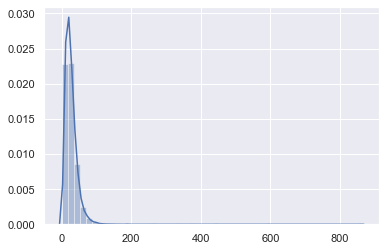

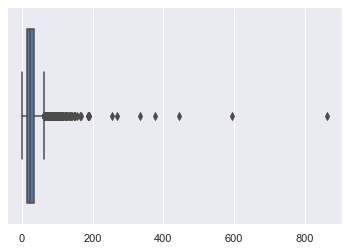

,sentence length
count,17621.000000
mean,26.679757
std,19.247341
min,2.000000
25%,15.000000
50%,23.000000
75%,34.000000
max,861.000000


In [8]:
sentence_len = np.array(list(map(len, xtrain_seq)))
print(-np.sort(-sentence_len)[:20])
print(np.argsort(-sentence_len)[:20])
sns.distplot(sentence_len)
plt.show()
sns.boxplot(sentence_len)
plt.show()
pd.DataFrame(sentence_len, columns=['sentence length']).describe()

In [9]:
max_len = 70

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)


In [10]:
print('original text:\n  ', xtrain[0], '\n')
print('sequence features:\n  ', xtrain_seq[0], '\n')
print('padded seq features:\n  ', xtrain_pad[0], '\n')
print('words:\n  ', [token.index_word.get(x, '___') for x in xtrain_pad[0]], '\n')

original text:
   Her hair was the brightest living gold, and despite the poverty of her clothing, seemed to set a crown of distinction on her head. 

sequence features:
   [29, 560, 8, 1, 5924, 459, 714, 3, 987, 1, 1794, 2, 29, 3695, 98, 4, 326, 5, 2545, 2, 3103, 27, 29, 166] 

padded seq features:
   [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   29  560    8    1 5924  459  714    3  987    1
 1794    2   29 3695   98    4  326    5 2545    2 3103   27   29  166] 

words:
   ['___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', '___', 'her'

In [11]:
with open('./data/glove.compress.embeddings.pickle', 'rb') as f:
    embeddings_index = pickle.load(f)

with open('./data/glove.compress.vocabulary.pickle', 'rb') as f:
    vocabulary = pickle.load(f)

# create an embedding matrix for the words we have in the dataset
embedding_width = len(embeddings_index['the'])
embedding_matrix = np.zeros((len(word_index) + 1, embedding_width))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print('shape of train matrix:', xtrain_pad.shape)
print('shape of embedding matrix:', embedding_matrix.shape)


shape of train matrix: (17621, 70)
shape of embedding matrix: (25944, 300)


In [12]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(
    Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )
)
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', ])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 11s 631us/sample - loss: 1.0831 - categorical_accuracy: 0.4118 - val_loss: 0.9647 - val_categorical_accuracy: 0.5460
Epoch 2/100
17621/17621 [==============================] - 8s 475us/sample - loss: 0.9661 - categorical_accuracy: 0.5371 - val_loss: 0.8674 - val_categorical_accuracy: 0.6359
Epoch 3/100
17621/17621 [==============================] - 8s 472us/sample - loss: 0.8870 - categorical_accuracy: 0.6033 - val_loss: 0.7866 - val_categorical_accuracy: 0.6905
Epoch 4/100
17621/17621 [==============================] - 8s 478us/sample - loss: 0.8430 - categorical_accuracy: 0.6266 - val_loss: 0.7704 - val_categorical_accuracy: 0.7007
Epoch 5/100
17621/17621 [==============================] - 8s 479us/sample - loss: 0.8175 - categorical_accuracy: 0.6424 - val_loss: 0.7530 - val_categorical_accuracy: 0.7114
Epoch 6/100
17621/17621 [==============================] - 8s 475us/sample 

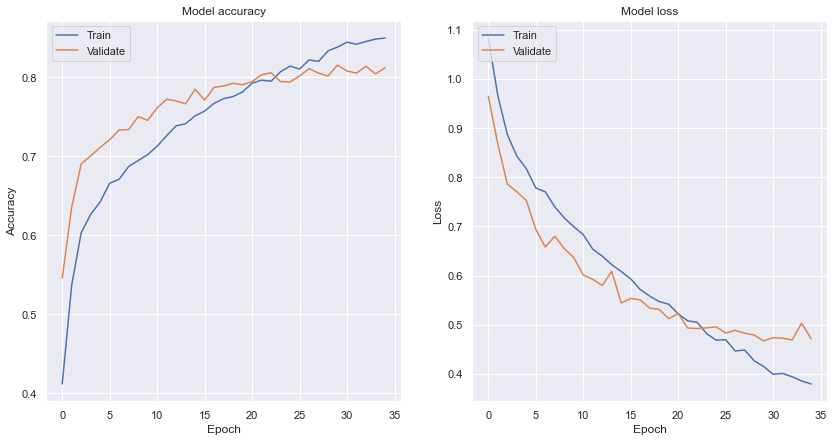

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           7783200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 300)           0         
_________________________________________________________________
gru (GRU)                    (None, 70, 300)           541800    
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               541800    
_________________________________________________________________
dense (Dense)                (None, 1024)              308224    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1

In [13]:
plot_keras_history(model.history)
model.summary()

train set: logloss: 0.208
valid set: logloss: 0.472
train set
              precision    recall  f1-score   support

         EAP      0.891     0.965     0.926      7110
         HPL      0.967     0.905     0.935      5071
         MWS      0.960     0.914     0.936      5440

    accuracy                          0.932     17621
   macro avg      0.939     0.928     0.932     17621
weighted avg      0.934     0.932     0.932     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.770     0.870     0.817       790
         HPL      0.839     0.785     0.811       564
         MWS      0.855     0.762     0.806       604

    accuracy                          0.812      1958
   macro avg      0.821     0.806     0.811      1958
weighted avg      0.816     0.812     0.812      1958



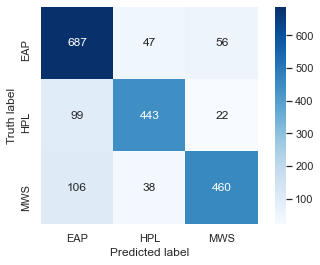

In [14]:
evaluate_model(model, 'GRU', xtrain_pad, ytrain, xvalid_pad, yvalid, fit=False)

In [15]:
# GRU with glove embeddings and two dense layers
alpha = 0.0005
L2 = regularizers.l2

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
# model.add(SpatialDropout1D(0.3))
model.add(GRU(
    300, dropout=0.3,
    recurrent_dropout=0.3, return_sequences=True,
    kernel_regularizer=L2(alpha), recurrent_regularizer=L2(alpha), bias_regularizer=L2(alpha),))
model.add(GRU(
    300, dropout=0.3,
    recurrent_dropout=0.3, kernel_regularizer=L2(alpha),
    recurrent_regularizer=L2(alpha), bias_regularizer=L2(alpha)))

model.add(Dense(1024, activation='relu', kernel_regularizer=L2(alpha), bias_regularizer=L2(alpha)))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu', kernel_regularizer=L2(alpha), bias_regularizer=L2(alpha)))
model.add(Dropout(0.8))

model.add(Dense(3, kernel_regularizer=L2(alpha), bias_regularizer=L2(alpha)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', ])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 11s 649us/sample - loss: 2.2466 - categorical_accuracy: 0.4474 - val_loss: 1.8637 - val_categorical_accuracy: 0.5628
Epoch 2/100
17621/17621 [==============================] - 8s 478us/sample - loss: 1.7195 - categorical_accuracy: 0.5953 - val_loss: 1.5035 - val_categorical_accuracy: 0.6834
Epoch 3/100
17621/17621 [==============================] - 9s 489us/sample - loss: 1.4792 - categorical_accuracy: 0.6440 - val_loss: 1.3455 - val_categorical_accuracy: 0.6997
Epoch 4/100
17621/17621 [==============================] - 9s 488us/sample - loss: 1.3436 - categorical_accuracy: 0.6630 - val_loss: 1.2276 - val_categorical_accuracy: 0.7043
Epoch 5/100
17621/17621 [==============================] - 9s 488us/sample - loss: 1.2556 - categorical_accuracy: 0.6676 - val_loss: 1.2132 - val_categorical_accuracy: 0.6629
Epoch 6/100
17621/17621 [==============================] - 9s 488us/sample 

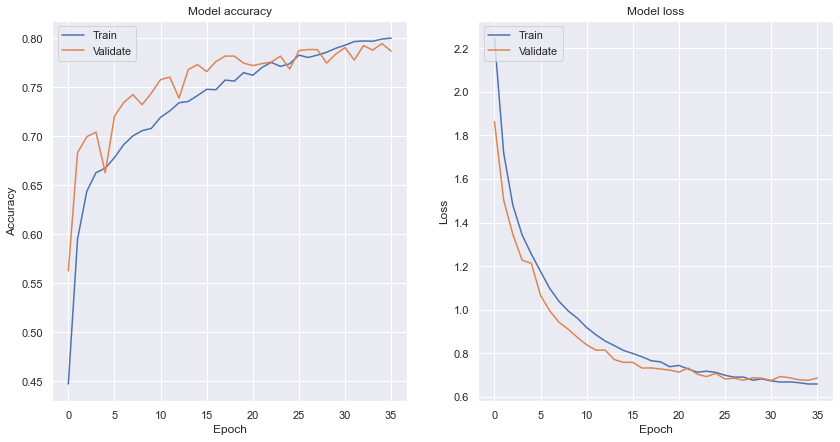

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           7783200   
_________________________________________________________________
gru_2 (GRU)                  (None, 70, 300)           541800    
_________________________________________________________________
gru_3 (GRU)                  (None, 300)               541800    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              308224    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

In [16]:
plot_keras_history(model.history)
model.summary()

train set: logloss: 0.373
valid set: logloss: 0.526
train set
              precision    recall  f1-score   support

         EAP      0.813     0.900     0.854      7110
         HPL      0.940     0.765     0.843      5071
         MWS      0.852     0.880     0.866      5440

    accuracy                          0.855     17621
   macro avg      0.868     0.848     0.854     17621
weighted avg      0.861     0.855     0.855     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.759     0.832     0.793       790
         HPL      0.861     0.713     0.780       564
         MWS      0.771     0.798     0.784       604

    accuracy                          0.787      1958
   macro avg      0.797     0.781     0.786      1958
weighted avg      0.792     0.787     0.787      1958



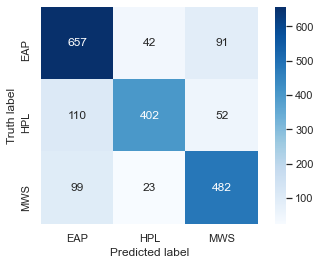

In [17]:
evaluate_model(model, 'GRU + L2(alpha=%d)' % (alpha, ), xtrain_pad, ytrain, xvalid_pad, yvalid, fit=False)

In [18]:
history

train            validate          
                    logloss  accuracy   logloss  accuracy
GRU                0.208226  0.927727  0.471632  0.805557
GRU + L2(alpha=0)  0.373389  0.848300  0.525691  0.780808